# Diagnostics in R

In this lesson, we will perform diagnostics to detect violations to the linearity, independence, constant variance, and normality assumptions on a regression model on real data in R.

Consider again our marketing data:


The following dataset containts measurements related to the impact of three advertising medias on sales of a product, $P$. The variables are:

- `youtube`: the advertising budget allocated to YouTube. Measured in thousands of dollars;

- `facebook`: the advertising budget allocated to Facebook. Measured in thousands of dollars; and 

- `newspaper`: the advertising budget allocated to a local newspaper. Measured in thousands of dollars.

- `sales`: the value in the $i^{th}$ row of the sales column is a measurement of the sales (in thousands of units) for product $P$ for company $i$.

The advertising data treat "a company selling product $P$" as the statistical unit, and "all companies selling product $P$" as the population. We assume that the $n = 200$ companies in the dataset were chosen at random from the population (a strong assumption!).

First, let's fit our regression model on the data.

In [6]:

install.packages("RCurl")

library(RCurl)



The downloaded binary packages are in
	/var/folders/j_/555m2zps099832fjh_m8jjnc0000gn/T//RtmpYVm9J1/downloaded_packages


Warning message:
“package ‘RCurl’ was built under R version 4.3.3”


In [7]:
library(RCurl) #a package that includes the function getURL(), which allows for reading data from github.
library(ggplot2)
url = getURL("https://raw.githubusercontent.com/bzaharatos/-Statistical-Modeling-for-Data-Science-Applications/master/Modern%20Regression%20Analysis%20/Datasets/marketing.txt")
marketing = read.csv(text = url, sep = "")

In [8]:
lm_marketing = lm(sales ~ facebook + youtube + newspaper, data = marketing)
summary(lm_marketing)


Call:
lm(formula = sales ~ facebook + youtube + newspaper, data = marketing)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.5932  -1.0690   0.2902   1.4272   3.3951 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.526667   0.374290   9.422   <2e-16 ***
facebook     0.188530   0.008611  21.893   <2e-16 ***
youtube      0.045765   0.001395  32.809   <2e-16 ***
newspaper   -0.001037   0.005871  -0.177     0.86    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.023 on 196 degrees of freedom
Multiple R-squared:  0.8972,	Adjusted R-squared:  0.8956 
F-statistic: 570.3 on 3 and 196 DF,  p-value: < 2.2e-16


## Diagnostics plots

In this lesson, we'll focus on dignostic visualizations over formal statistical tests.

### "Base R" diagnostics"

`R` can easily print out some diagnistic plots...

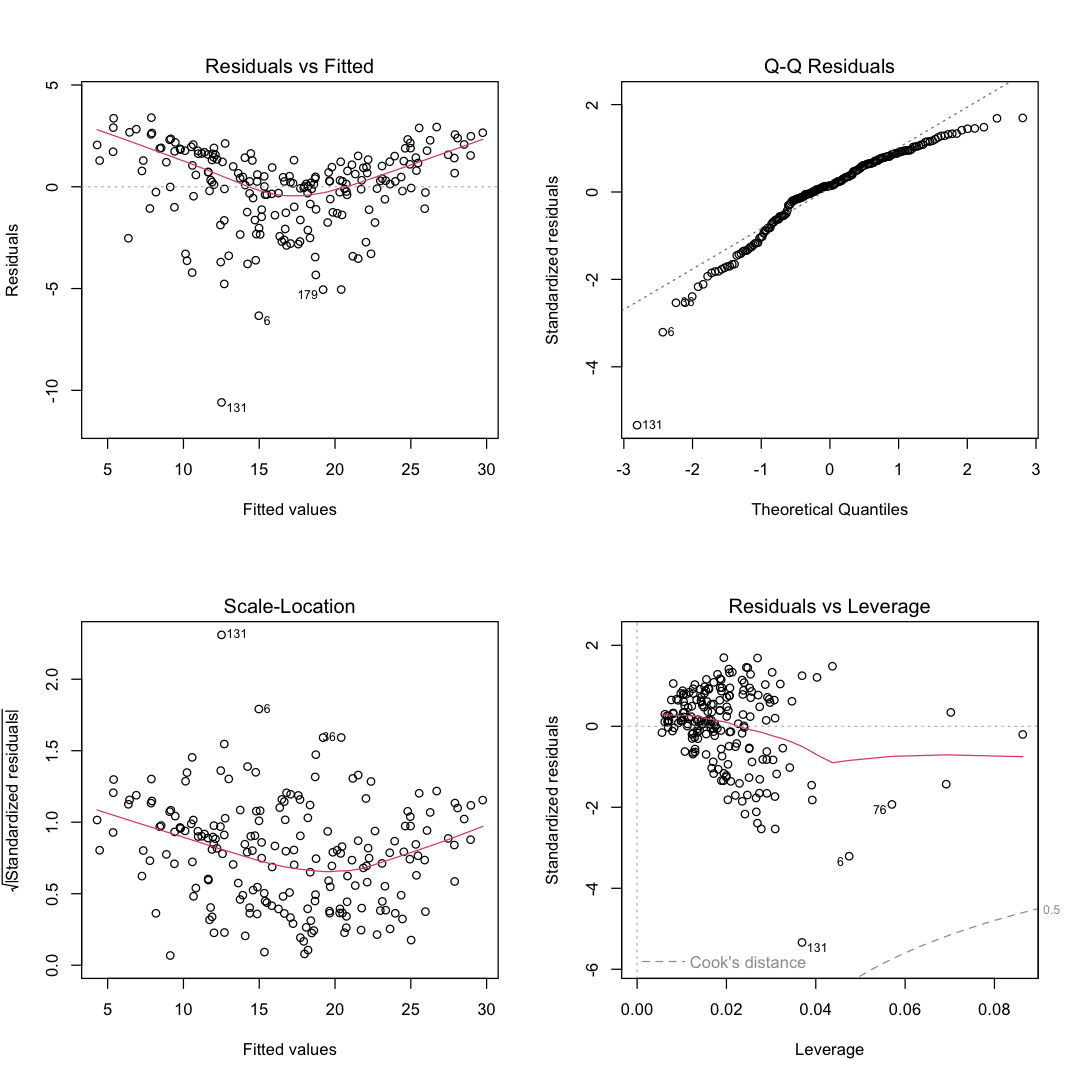

In [9]:
options(repr.plot.width = 9, repr.plot.height = 9)
par(mfrow = c(2,2))
plot(lm_marketing)

But these plots are kind of ugly. We can make them better with `ggplot`!

## Using `ggplot`

`ggplot` takes a bit more work to generate diagnostic plots. But the efforts are worth it, I think!

First, we'll need to store the quantities important to diagnostics in a data frame.

In [10]:
df.diagnostics = data.frame(yhat = fitted(lm_marketing), r = resid(lm_marketing), y = marketing$sales,
                           youtube = marketing$youtube, facebook = marketing$facebook, newspaper = marketing$newspaper)

##### Linearity, nonconstant variance, and normality

Now, let's take a look at potential violations of the linearity, nonconstant variance, and normality assumptions.

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


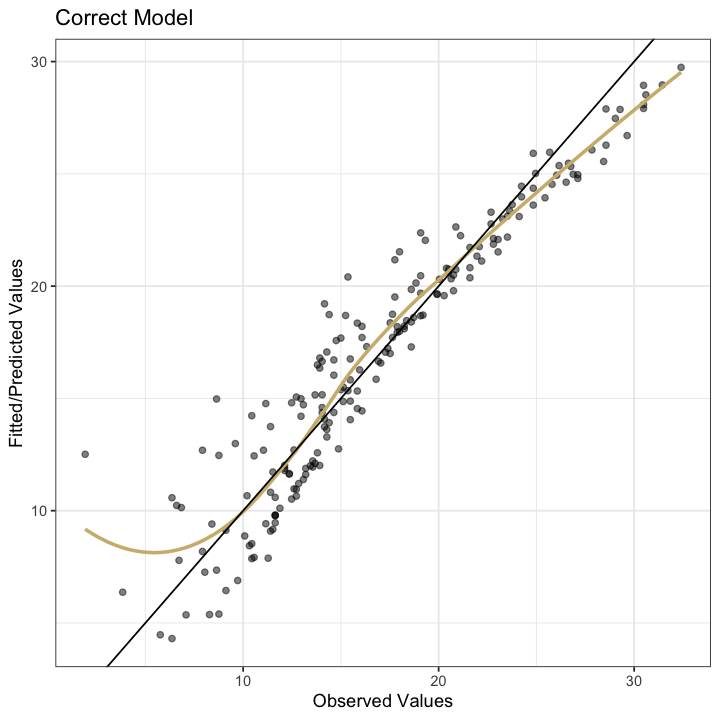

In [11]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(df.diagnostics, aes(x = y, y = yhat)) + 
    geom_point(alpha = 0.5) + 
    geom_smooth(se = F, col = "#CFB87C") +
    geom_abline(intercept = 0, slope = 1)+
    xlab("Observed Values") +
    ylab("Fitted/Predicted Values") +
    ggtitle("Correct Model") +
    theme_bw()

The observed vs predicted value plot should follow the black line, $y = x$, with only random deviations. Instead, the plot shows some curvature, as captured by the gold curve. This curvature shows that, for high values of the response, say, above about $22$, the model is underpredicting (because the fitted values are lower than the observed values). For middle values of the response, there is an overprediction, and for low values of the response, there's perhaps some underpredicting, but with more variability. All of this suggests that the structural part of the model is misspecified. 

Now let's look at the residual vs fitted values plot.

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


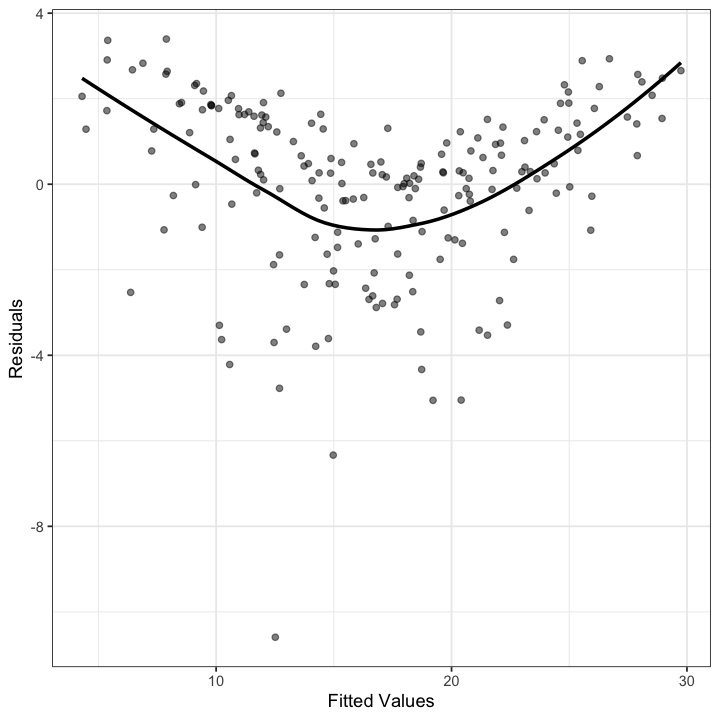

In [12]:
ggplot(df.diagnostics, aes(x = yhat, y = r)) + 
    geom_point(alpha = 0.5) + 
    geom_smooth(se = F, col = "black") +
    xlab("Fitted Values") + ylab("Residuals")+
    theme_bw()

Here, we corroborate our result from the observed vs fitted plot: that there is some curvature in the data not being captured by our model. However, we note that, other than the outlier (very small residual), we don't seem to see a difference in variability of the residuals across the fitted values. So, we do not have evidence of a violation in the nonconstant variance assumption. 

Given the structural issues with the model, it is difficult to use this plot to assess the normality assumption. In general, we should probably stop here to address the issues we have before moving on to the normality assumption. But let's take a quick look at a qq plot:

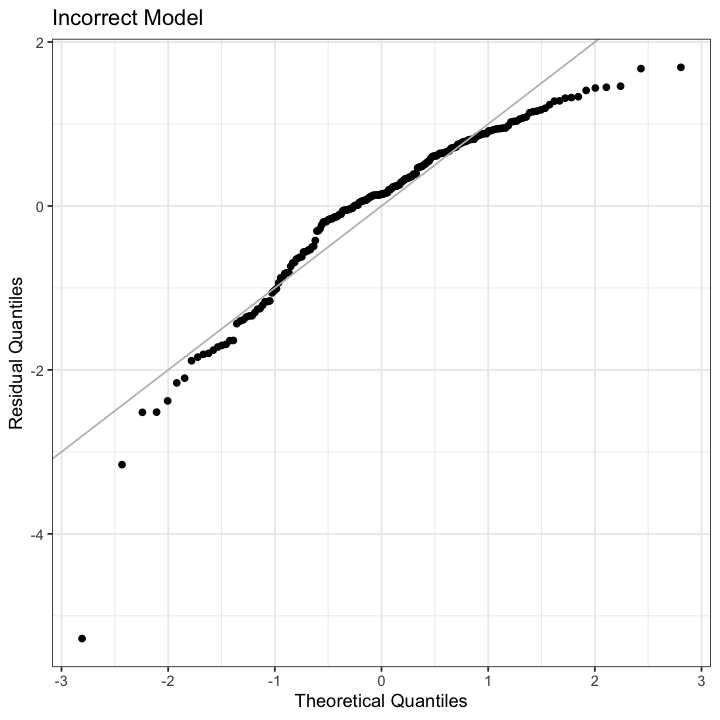

In [13]:
ggplot(df.diagnostics, aes(sample = (r - mean(r))/sd(r))) + 
    stat_qq() + geom_abline(slope = 1, intercept = 0, col = "grey") +
    xlab("Theoretical Quantiles") +
    ylab("Residual Quantiles") +
    ggtitle("Incorrect Model") +
    theme_bw()

There is some deviation from normality, especially in the tails of the distribution. The nonnormality that we're seeing here is likely due to (1) the outlier, and (2) the violation of the linearity assumption.

### Independence

To assess the independence assumption, let's take a look at a successive residual plot and a residual vs index plot. Note that the data doesn't provide us with any *natural* ordering, e.g., time or distance measurements. So, let's first just use the ordering given to us.

[1] -0.0470919

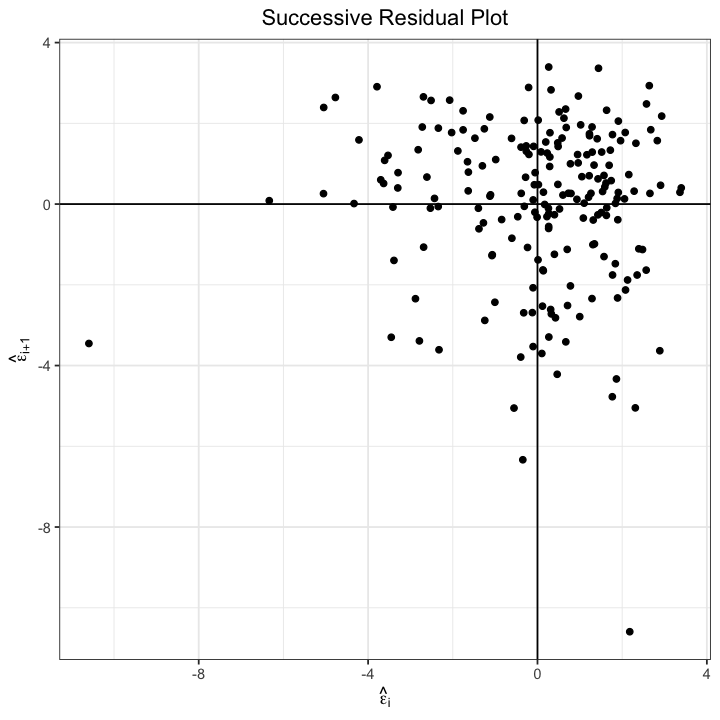

In [14]:
n = dim(marketing)[1]; 
x = head(df.diagnostics$r, n-1)
y = tail(df.diagnostics$r, n-1)
cor(x,y)
srp = data.frame(x,y)
ggplot(srp, aes(x = x, y = y)) + 
    geom_point() + 
    geom_vline(xintercept = 0) + 
    geom_hline(yintercept = 0) + 
    xlab(expression(hat(epsilon)[i])) +
    ylab(expression(hat(epsilon)[i+1])) + 
    ggtitle("Successive Residual Plot") + 
    theme_bw() + 
    theme(plot.title = element_text(hjust = 0.5)) 

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


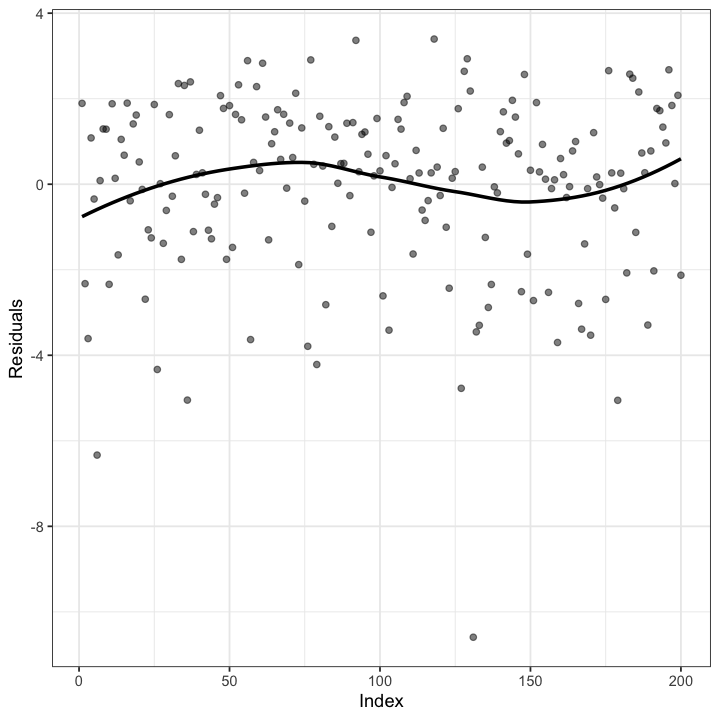

In [15]:
ggplot(df.diagnostics, aes(x = 1:length(marketing$sales), y = r)) + 
    geom_point(alpha = 0.5) + 
    xlab("Index") +
    geom_smooth(se = F, col = "black") +
    ylab("Residuals") +
    theme_bw()

Unsurprisingly, given a lack of a natural ordering, we don't see any real patterns in this plot. maybe we can order the points according the different budgets. We can start with `youtube`:

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::complete() masks RCurl::complete()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


,yhat,r,y,youtube,facebook,newspaper
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
131,12.513225,-10.593225,1.92,0.84,47.52,10.44
156,6.369071,-2.529071,3.84,4.92,13.92,6.84
79,10.575976,-4.215976,6.36,6.48,35.88,11.28
57,10.233255,-3.633255,6.60,8.76,33.72,49.68
127,12.692609,-4.772609,7.92,9.36,46.68,60.72
133,10.138980,-3.298980,6.84,10.08,32.64,2.52


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


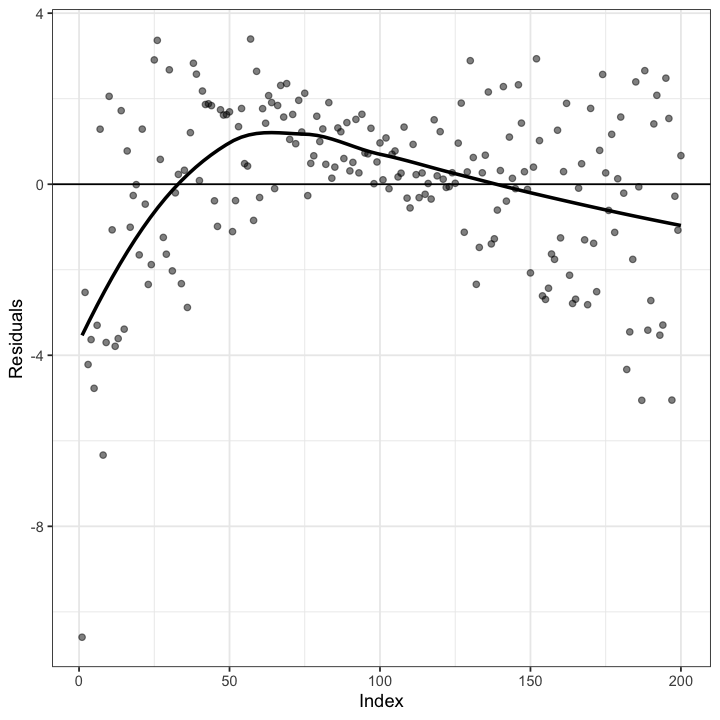

In [16]:
library(tidyverse)
df.diagnostics.order = arrange(df.diagnostics, youtube) #order the data according to the youtube variable
head(df.diagnostics.order)

ggplot(df.diagnostics.order, aes(x = 1:length(marketing$sales), y = r)) + 
    geom_point(alpha = 0.5) + 
    geom_abline(slope = 0, intercept = 0) +
    xlab("Index") +
    geom_smooth(se = F, col = "black") +
    ylab("Residuals") +
    theme_bw()

If the independence assumption is satisfied, the residuals will be randomly scattered around zero; there shouldn't be any correlation between successive errors under this ordering. But there does appear to be some structure. This structure may be due to the nonlinearity in the data, but there's also a higher correlation between successive residuals when ordered with respect to `youtube`.

I'll leave it as an exercise to look at other possible orderings!

In [17]:
x = head(df.diagnostics.order$r, n-1)
y = tail(df.diagnostics.order$r, n-1)
cor(x,y)

[1] 0.2516592

At this point, we've uncovered some assumption violations:

- There seems to be curvature in the data that our model is not capturing (i.e., a violation of the linearity assumption).

- We also see violations to the normality assumption, and potentially to the independence assumption. But these violations may be due to the violation of the linearity; that is, if we added a predictor that captured the systematic variability in the data, we might see better qq plots and residual plots.